## Noisy RGB pixel only, ~~VGG perceptual loss~~ L1 loss, 1/8 U-Net bottleneck, ~~L1 + L2 regularization~~

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


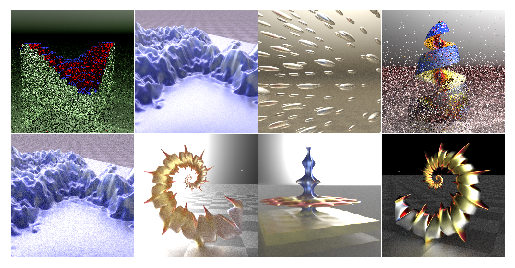

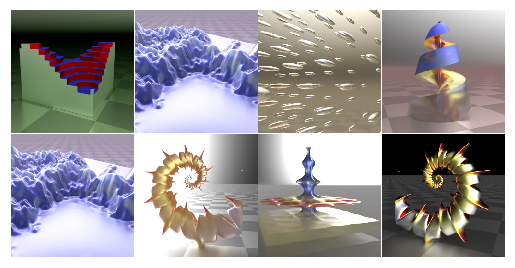

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
# plot_imgs(a[:, 0:3])
# plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 48
        n3 = 64
        self.econv0a = conv3(3, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(64, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0): Conv2d(16, 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
128 0.05020006746053696
256 0.045094579458236694
384 0.05325300991535187
512 0.04290419816970825
640 0.03516468405723572
768 0.02944919839501381
896 0.024884115904569626
1024 0.022773191332817078
1152 0.026938285678625107
1280 0.029027923941612244
1408 0.016617324203252792
1536 0.02435324713587761
1664 0.019149668514728546
1792 0.021661682054400444
1920 0.01470608077943325
2048 0.021182004362344742
2176 0.016531050205230713
2304 0.016222437843680382
2432 0.019471582025289536
2560 0.013951897621154785
2688 0.022895192727446556
2816 0.014357573352754116
2944 0.017137810587882996
3072 0.01809382438659668
3200 0.012295646592974663
3328 0.007128163706511259
3456 0.009626725688576698
3584 0.01675749197602272
3712 0.014690136536955833
3840 0.02029251866042614
3968 0.01636812463402748
4

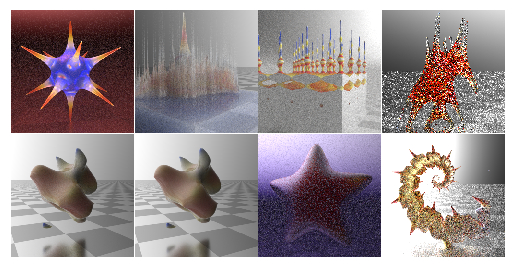

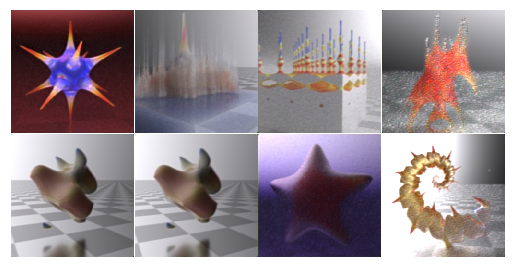

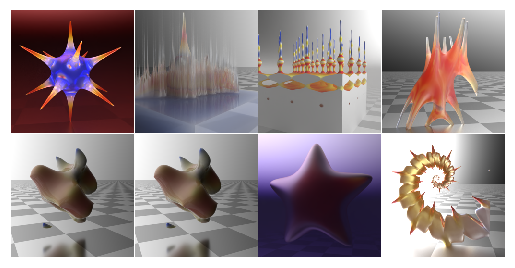

4224 0.014491098001599312
4352 0.014503869228065014
4480 0.015181554481387138
4608 0.014294851571321487
4736 0.019342318177223206
4864 0.017937250435352325
4992 0.016139987856149673
5120 0.011896832846105099
5248 0.0144544318318367
5376 0.01176389493048191
5504 0.016198655590415
5632 0.012177867814898491
5760 0.014946645125746727
5888 0.009255537763237953
6016 0.011816086247563362
6144 0.01212354190647602
6272 0.011537661775946617
6400 0.012192709371447563
6528 0.015727343037724495
6656 0.017670154571533203
6784 0.019409991800785065
6912 0.016608282923698425
7040 0.011824807152152061
7168 0.014427363872528076
7296 0.01740146055817604
7424 0.015487590804696083
7552 0.013448212295770645
7680 0.014382926747202873
7808 0.010808274149894714
7936 0.009386765770614147
8064 0.010587019845843315
8192 0.010110425762832165


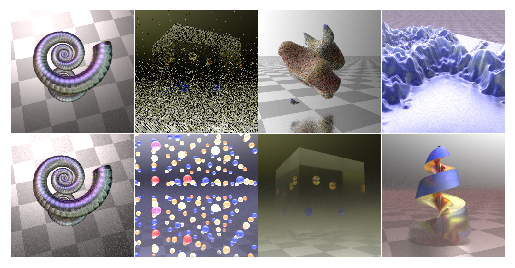

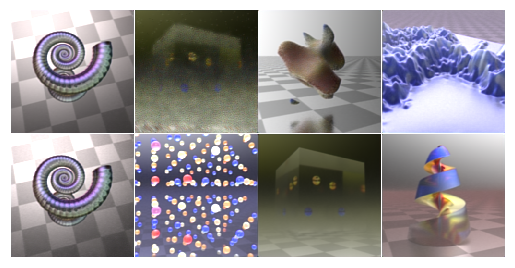

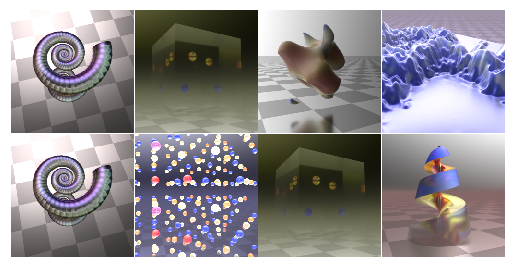

8320 0.011521967127919197
8448 0.013970739208161831
8576 0.012430539354681969
8704 0.008172323927283287
8832 0.010004769079387188
8960 0.013866012915968895
9088 0.013319677673280239
9216 0.012563849799335003
9344 0.011922024190425873
9472 0.008601151406764984
9600 0.014452584087848663
9728 0.016178520396351814
9856 0.01041654497385025
9984 0.020781761035323143
10112 0.012974053621292114
10240 0.01649286225438118
10368 0.018000740557909012
10496 0.019465502351522446
10624 0.013764701783657074
10752 0.012410322204232216
10880 0.015464365482330322
11008 0.0090351402759552
11136 0.014392371289432049
11264 0.008902846835553646
11392 0.009914412163197994
11520 0.008652720600366592
11648 0.008764698170125484
11776 0.011931787244975567
11904 0.00973319262266159
12032 0.010000345297157764
12160 0.009655876085162163
12288 0.014623977243900299


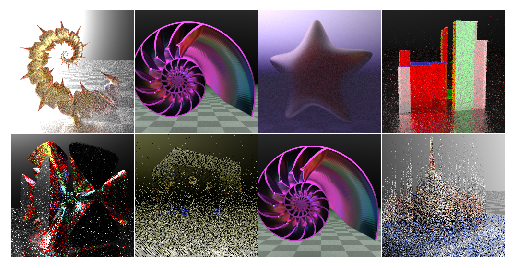

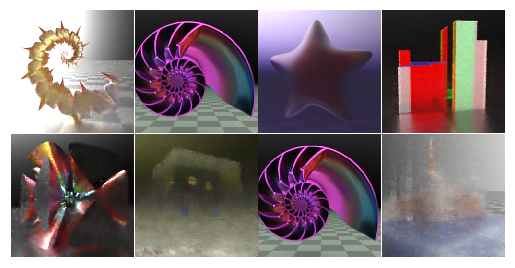

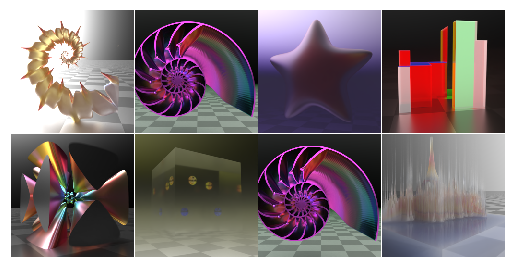

12416 0.011855658143758774
12544 0.011423583142459393
12672 0.010979393497109413
12800 0.014212733134627342
12928 0.014441939070820808
13056 0.007668410427868366
13184 0.007151066791266203
13312 0.012263724580407143
13440 0.007645649369806051
13568 0.01549937017261982
13696 0.010727028362452984
13824 0.01356448046863079
13952 0.010334024205803871
14080 0.01502789556980133
14208 0.00933954119682312
14336 0.012642323970794678
14464 0.014943849295377731
14592 0.014846835285425186
14720 0.012958879582583904
14848 0.012499368749558926
14976 0.008074315264821053
15104 0.009948697872459888
15232 0.008344769477844238
15360 0.011318053118884563
15488 0.0111750029027462
15616 0.016249313950538635
15744 0.012028191238641739
15872 0.01556453388184309
16000 0.012516697868704796
16128 0.011927478015422821
16256 0.009968111291527748
16384 0.010435117408633232


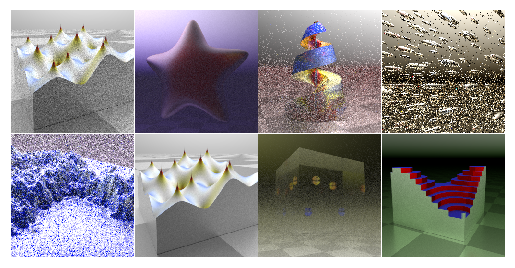

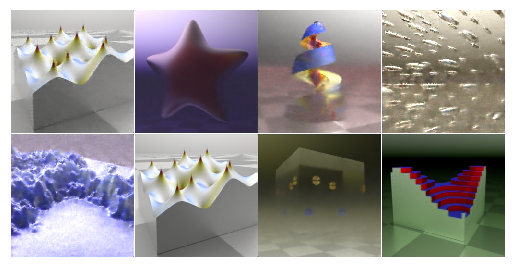

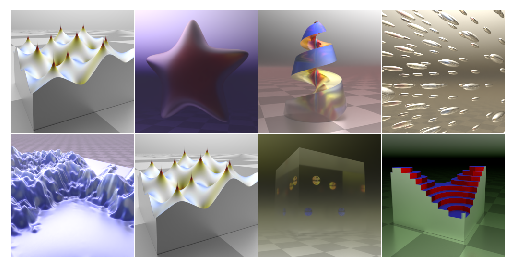

16512 0.012031985446810722
16640 0.00997948832809925
16768 0.01765846461057663
16896 0.008093936368823051
17024 0.0074645704589784145
17152 0.010041299276053905
17280 0.006286626681685448
17408 0.014817953109741211
17536 0.011188111267983913
17664 0.010154807940125465
17792 0.012537620961666107
17920 0.011514648795127869
18048 0.008031516335904598
18176 0.010381798259913921
18304 0.018483659252524376
18432 0.011151298880577087
18560 0.007544512860476971
18688 0.012288535945117474
18816 0.011582355946302414
18944 0.011253382079303265
19072 0.013389374129474163
19200 0.0063192350789904594
19328 0.007993405684828758
19456 0.01299617625772953
19584 0.0070036351680755615
19712 0.010535410605370998
19840 0.009740425273776054
19968 0.012998096644878387
20096 0.013744443655014038
20224 0.011653177440166473
20352 0.007096298038959503
20480 0.013126942329108715


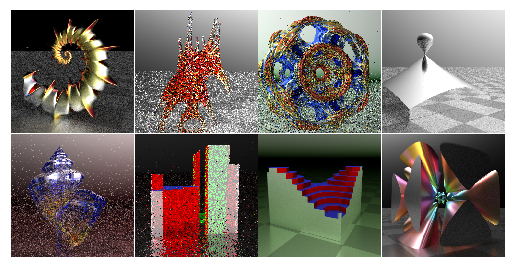

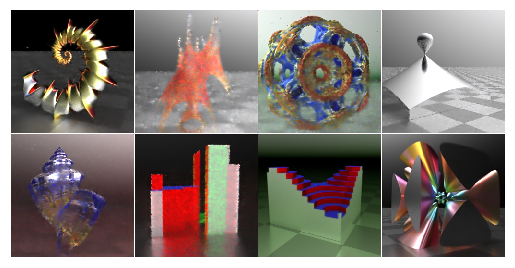

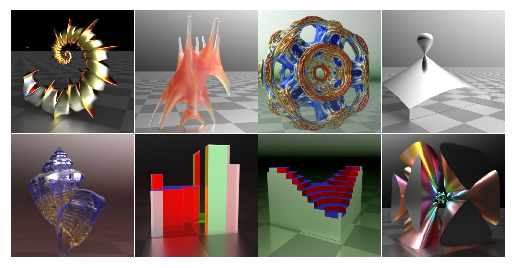

20608 0.009974210523068905
20736 0.010540001094341278
20864 0.01095785852521658
20992 0.007773726247251034
21120 0.007832597941160202
21248 0.004515357315540314
21376 0.013071082532405853
21504 0.009054126217961311
21632 0.00955891702324152
21760 0.006233914755284786
21888 0.016007641330361366
22016 0.005546716973185539
22144 0.008858537301421165
22272 0.01096422504633665
22400 0.008362873457372189
22528 0.010647587478160858
22656 0.01005019061267376
22784 0.010873226448893547
22912 0.0062421574257314205
23040 0.014759264886379242
23168 0.01172645203769207
23296 0.015191096812486649
23424 0.008224410936236382
23552 0.008005237206816673
23680 0.01669473387300968
23808 0.01203705370426178
23936 0.009039046242833138
24064 0.005907665006816387
24192 0.012229125015437603
24320 0.014090903103351593
24448 0.015430254861712456
24576 0.010332154110074043


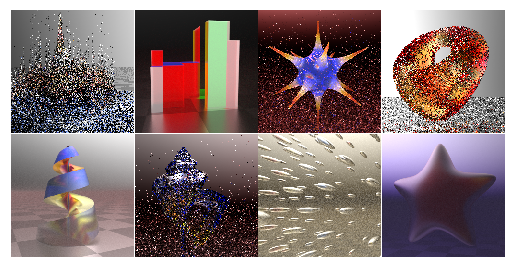

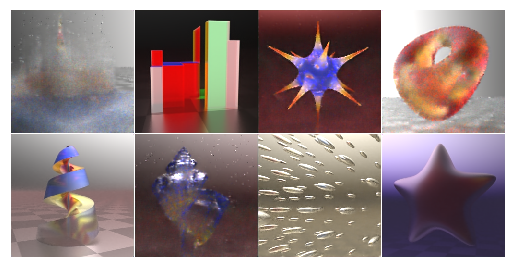

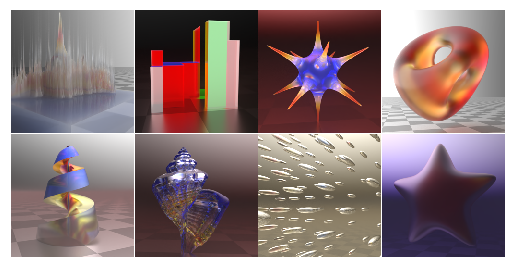

24704 0.004766709636896849
24832 0.009871294721961021
24960 0.007339480798691511
25088 0.01064557209610939
25216 0.007228522561490536
25344 0.011569598689675331
25472 0.010499905794858932
25600 0.012715938501060009
25728 0.007892477326095104
25856 0.013829141855239868
25984 0.008764437399804592
26112 0.010009760968387127
26240 0.012391919270157814
26368 0.013996889814734459
26496 0.010336948558688164
26624 0.00982580054551363
26752 0.009342504665255547
26880 0.012237015180289745
27008 0.00837469007819891
27136 0.014386599883437157
27264 0.006917714141309261
27392 0.010168885812163353
27520 0.01121489517390728
27648 0.009512003511190414
27776 0.013755029067397118
27904 0.007090780884027481
28032 0.0075315432623028755
28160 0.011665256693959236
28288 0.010375993326306343
28416 0.009987978264689445
28544 0.010901791974902153
28672 0.013431956991553307


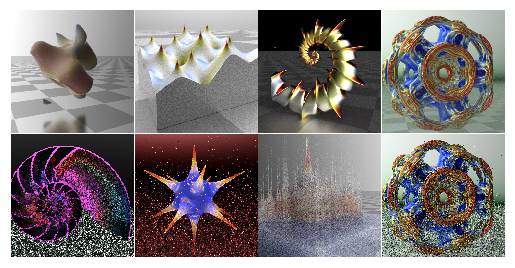

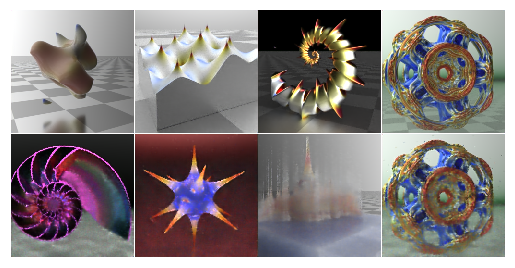

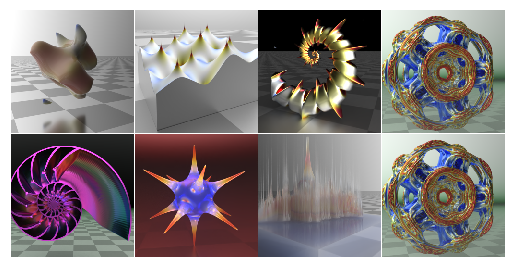

28800 0.009837010875344276
28928 0.008983669802546501
29056 0.006802818737924099
29184 0.008587776683270931
29312 0.010581674054265022
29440 0.009722637943923473
29568 0.011268705129623413
29696 0.011595009826123714
29824 0.0070448266342282295
29952 0.005517383571714163
30080 0.006460762582719326
30208 0.0072112372145056725
30336 0.007516147568821907
30464 0.008055494166910648
30592 0.00974977295845747
30720 0.013731546700000763
30848 0.011969885788857937
30976 0.005117729306221008
31104 0.005201834719628096
31232 0.01233491487801075
31360 0.007383297197520733
31488 0.010862521827220917
31616 0.0059843785129487514
31744 0.01878592185676098
31872 0.013957865536212921
32000 0.007837638258934021
32128 0.0067959558218717575
32256 0.00822374876588583
32384 0.010206337086856365
32512 0.010415635071694851
32640 0.008887991309165955
32768 0.008581380359828472


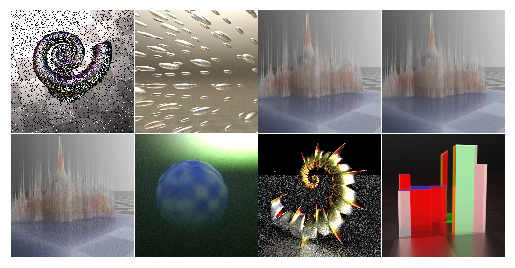

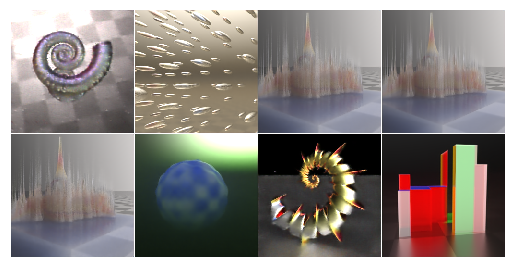

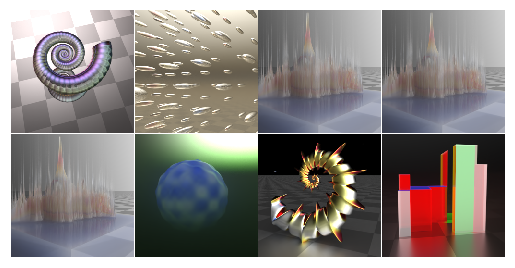

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
vgg16_head = vgg16_features[:4].to(device)
print(vgg16_head)

def lossfun(output, reference, input):
    r1 = torch.mean(torch.abs(output-reference))
    return r1
    r2 = torch.mean(torch.abs(vgg16_head(output)-vgg16_head(reference)))
    return r2
    # return 0.5*r1 + 0.5*r2

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        output = model(x)
        loss = lossfun(output, y, x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1c.pth")